# Houseprice Prediction 

In [4]:
#import  libraries
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
from scipy import stats
from scipy.stats import norm, skew
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats to 3 decimal points

import the train data and test data

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [82]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,1.276
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,1.273
2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,1.278
3,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,1.268
4,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,1.280


In [15]:
train.shape

(1460, 81)

In [14]:
test.shape

(1459, 80)

The train data consists of 1460 rows and 81 columns and the test data consists of 1459 rows and 80 columns 

In [17]:
train_ID = train['Id']
test_ID = test['Id']
train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

The next step is to explore the data further 
The plot below is a scatterplot of the train data: GrLiv Area versus SalePrice

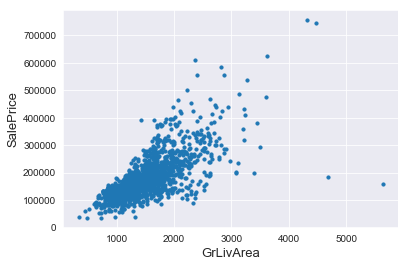

In [20]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'], s = 10)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Those two points down right have to be deleted since they have extremely large living area, but low sales price
Code below works to get rid of those two.

In [34]:
train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index #get indices of  two data points

Int64Index([523, 1298], dtype='int64')

In [36]:
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)

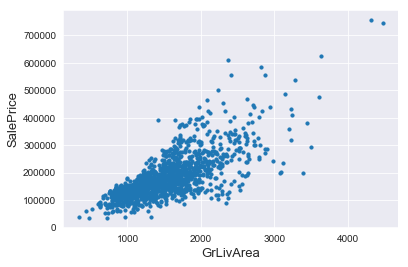

In [37]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'], s = 10)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

## Prediction Variable

SalePrice variable is what we need to predict in this project, so there is further infomation

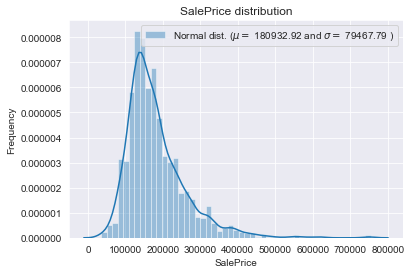

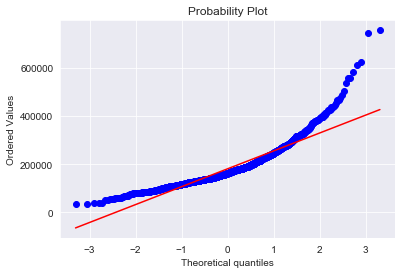

In [54]:
#first plot
sns.distplot(train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#second plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

From both of the plots, it is easy to recognize sale price distribution is skewed to the right. Therefore, we use logarithmic scale to adjust the distriution.

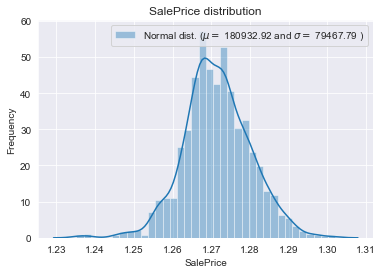

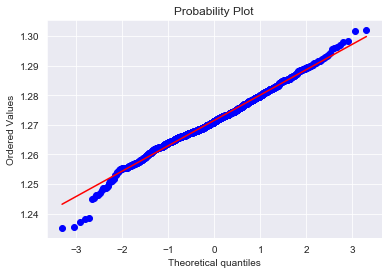

In [58]:
train['SalePrice'] = np.log1p(train['SalePrice'])

sns.distplot(train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

We have modified the skewness of sale price

In [70]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

In [98]:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print(all_data.shape)

(2917, 79)


/Users/yutahayashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Missing Value

In [99]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100 #percentage
all_data_na[all_data_na == 0].index

all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Imputation

**PoolQC:** The houses without pools attain NaN. Replace NaN with None

In [110]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

**MiscFeature:** The houses without music feature attain NA. Replace NA with None

In [111]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

**Alley:** The houses without alley access attain NA. Replace NA with None

In [112]:
all_data['Alley'] = all_data['Alley'].fillna('None')

**Fence:** The houses without fence attain NA. Replace NA with None

In [113]:
all_data['Fence'] = all_data['Fence'].fillna('None')

**FireplaceQu:** The houses without fire place attain NA. Replace NA with None

In [114]:
all_data['FirepalceQu'] = all_data['FireplaceQu'].fillna('None')

**LotFrontage:** 


Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood, we can fill in missing values by the median LotFrontage of the neighborhood.

In [126]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

**GarageType, GarageFinish, GarageQual and GarageCond:** Replace missing data with None

In [128]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

**GarageYrBlt, GarageArea and GarageCars:** Replace missing data with 0 (Since No garage = no cars in such garage.)

In [131]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

**BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath:** missing values are the ones that have no basement

In [132]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

**BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2:** 

For all these categorical basement-related features, NaN means that there is no basement.

In [ ]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

**MasVnrArea and MasVnrTyp:** NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [133]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

**MSZoning (The general zoning classification):** 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [138]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

**Utilities:** 

For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [142]:
all_data = all_data.drop(['Utilities'], axis=1)

**Functional:** data description says NA means typical

In [143]:
all_data["Functional"] = all_data["Functional"].fillna("Typical")

**Electrical:** It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [147]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

**KitchenQual:** Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [148]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

**Exterior1st and Exterior2nd:** Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [149]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

**SaleType:** Fill in again with most frequent which is "WD"

In [150]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

**MSSubClass:** Na most likely means No building class. We can replace missing values with None

In [151]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

Correlation

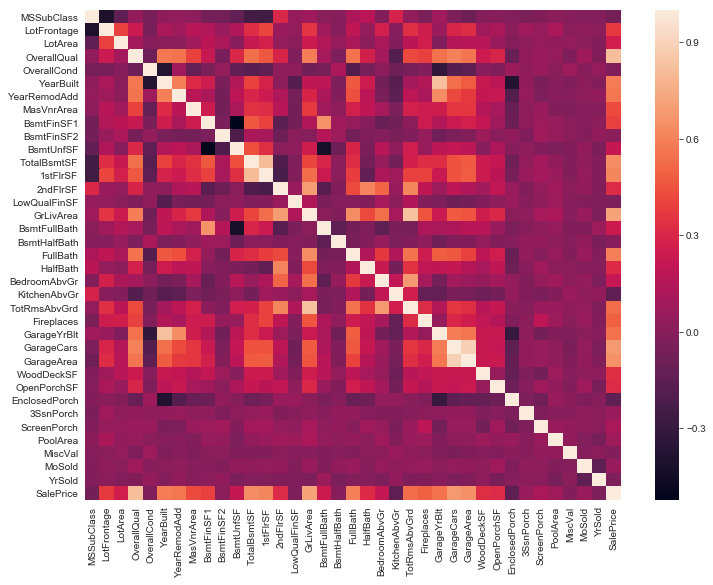

In [154]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat)

Transform numerical values that are categorical

In [165]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

Label Encoder

In [166]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 79)


## Adding one more important feature

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [167]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## Skewed features

Check the skewness of numeric variables

In [171]:
numeric_ft = all_data.dtypes[all_data.dtypes != "object"].index
skewed_ft = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew' :skewed_ft})
skewness.head(10)

,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


**Box Cox Transformation of skewed features:**


We use the scipy function boxcox1p which computes the Box-Cox transformation of  $1+x$.
Note that setting  $\lambda$ = 0  is equivalent to log1p used above for the target variabl

In [172]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


## Getting dummy 

In [173]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 226)


## Split the train data and the test data again

In [174]:
train = all_data[:ntrain]
test = all_data[ntrain:]